<a href="https://colab.research.google.com/github/AntoniZalewski/AI-ArtCategorizer/blob/main/Model_AI_ForRecognizingArtTypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns

Dominanitng an oline game with objcet detection using openCV.  Calritycoders

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Wczytywanie folderu zdjęć z dysku googla

In [ ]:
data_dir = '/content/drive/MyDrive/PROJECT_DATASETS'
train_dir = os.path.join(data_dir, '/content/drive/MyDrive/PROJECT_DATASETS/training_set')
validation_dir = os.path.join(data_dir, '/content/drive/MyDrive/PROJECT_DATASETS/validation_set')

Tworzenie funkcji ktora konwertuje i zdjecia zebym mogl je podpiac pod training set i test sety
oraz usunie nie czytane rodzaje plików

In [ ]:
def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = sorted([d.name for d in os.scandir(directory) if d.is_dir()])
    class_indices = {name: index for index, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            try:
                with Image.open(file_path) as img:
                    img = img.convert('L')  # Convert image to grayscale
                    img = img.resize((128, 128))  # Resize images
                    images.append(np.array(img))
                    labels.append(class_indices[class_name])
            except (IOError, SyntaxError) as e:
                print(f'Pominięto nieobsługiwany plik: {file_path}')

    return np.array(images), np.array(labels), class_names



In [ ]:
X_train, y_train, class_names = load_images_from_directory(train_dir)
X_test, y_test, _ = load_images_from_directory(validation_dir)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
X_train = X_train.reshape(-1, 128, 128, 1)
X_test = X_test.reshape(-1, 128, 128, 1)

In [ ]:

y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train)

(7721, 128, 128, 1)
(856, 128, 128, 1)
[0 0 0 ... 4 4 4]


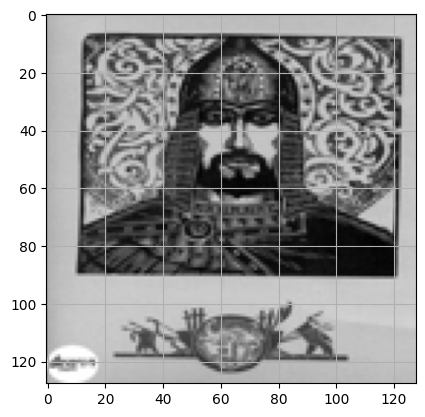

In [ ]:
sample = 1234
image = X_train[sample]

# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.grid()
plt.show()

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.layers import LeakyReLU, BatchNormalization


model = keras.models.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(100, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(len(class_names), activation="softmax", kernel_regularizer=regularizers.l2(0.001))
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min")

early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)


In [ ]:
import os
root_logdir = os.path.join(os.curdir, "PROJECT_DATASETS")
def get_run_logdir():
  import time
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb, lr_scheduler]
)

Epoch 1/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - accuracy: 0.6515 - loss: 2.2042 - val_accuracy: 0.5783 - val_loss: 2.3747 - learning_rate: 0.0010
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 42s 174ms/step - accuracy: 0.6726 - loss: 1.9355 - val_accuracy: 0.5047 - val_loss: 2.2020 - learning_rate: 0.0010
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 81s 167ms/step - accuracy: 0.6796 - loss: 1.8225 - val_accuracy: 0.7103 - val_loss: 1.7003 - learning_rate: 0.0010
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.7057 - loss: 1.7714 - val_accuracy: 0.3610 - val_loss: 3.5177 - learning_rate: 0.0010
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.7105 - loss: 1.8606 - val_accuracy: 0.7009 - val_loss: 1.8261 - learning_rate: 0.0010
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.7188 - loss: 1.8210 - val_accuracy: 0.6928 - val_loss: 1.9378 - learning_rate: 0.0010
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.7238 

In [ ]:
model.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7209 - loss: 0.9747


[0.793042778968811, 0.8294392228126526]

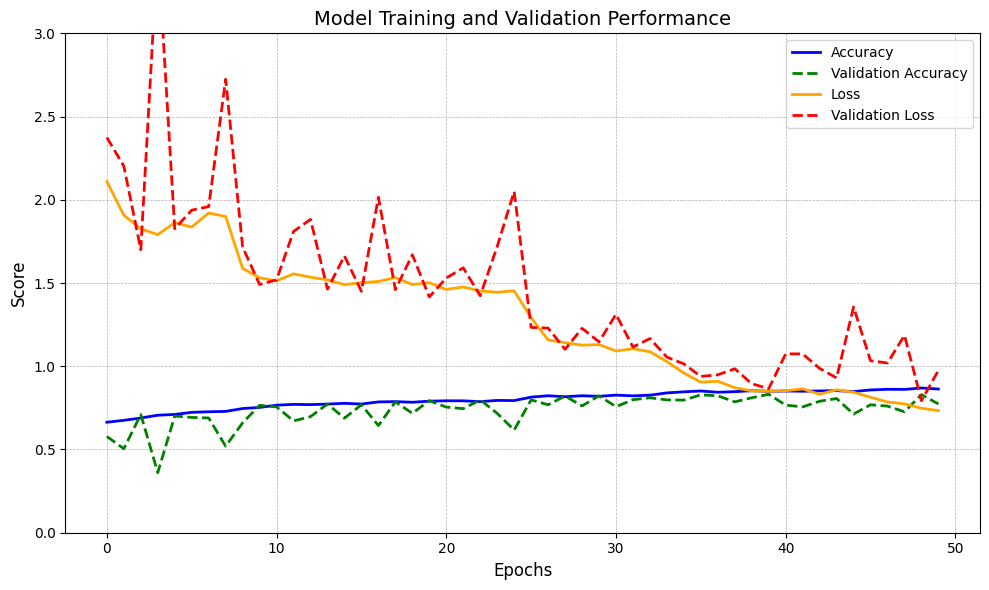

In [ ]:
# Plot history
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(10, 6))

# Plot accuracy and loss on primary y-axis
plt.plot(history_df['accuracy'], label='Accuracy', color='blue', linewidth=2)
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', color='green', linewidth=2, linestyle='--')
plt.plot(history_df['loss'], label='Loss', color='orange', linewidth=2)
plt.plot(history_df['val_loss'], label='Validation Loss', color='red', linewidth=2, linestyle='--')

# Add labels and title
plt.title('Model Training and Validation Performance', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Score', fontsize=12)

# Set y-axis limits
plt.ylim(0, 3)

# Add grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()